In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
%matplotlib inline

In [2]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [3]:
weekly_sales_df = pd.read_csv('train.csv', header=0, parse_dates=['Date'])

In [4]:
weekly_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


### EDA

In [5]:
## define a function to visualize the sales data for stores and depts

def eda_sales(df, store_locations, departments):
    nrow = len(store_locations)
    ncol = len(departments)
    
    fig,ax = plt.subplots(nrow,ncol)
    r = 0
    c = 0
    
    for store in store_locations:
        c = 0
        for dept in departments:
            df_str_dept = df[(df['Store']==store) & (df['Dept']==dept)][['Date', 'Weekly_Sales']]
            df_str_dept = df_str_dept.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}) #rename the cols as needed by fbprophet
            df_str_dept.set_index('ds').y.plot(ax=ax[r,c], sharey=True,figsize=(18,18),title='Weekly Sales for Store %d - Dept %d' %(store,dept))        
            c += 1
            plt.tight_layout()
                                               
        r += 1                                 

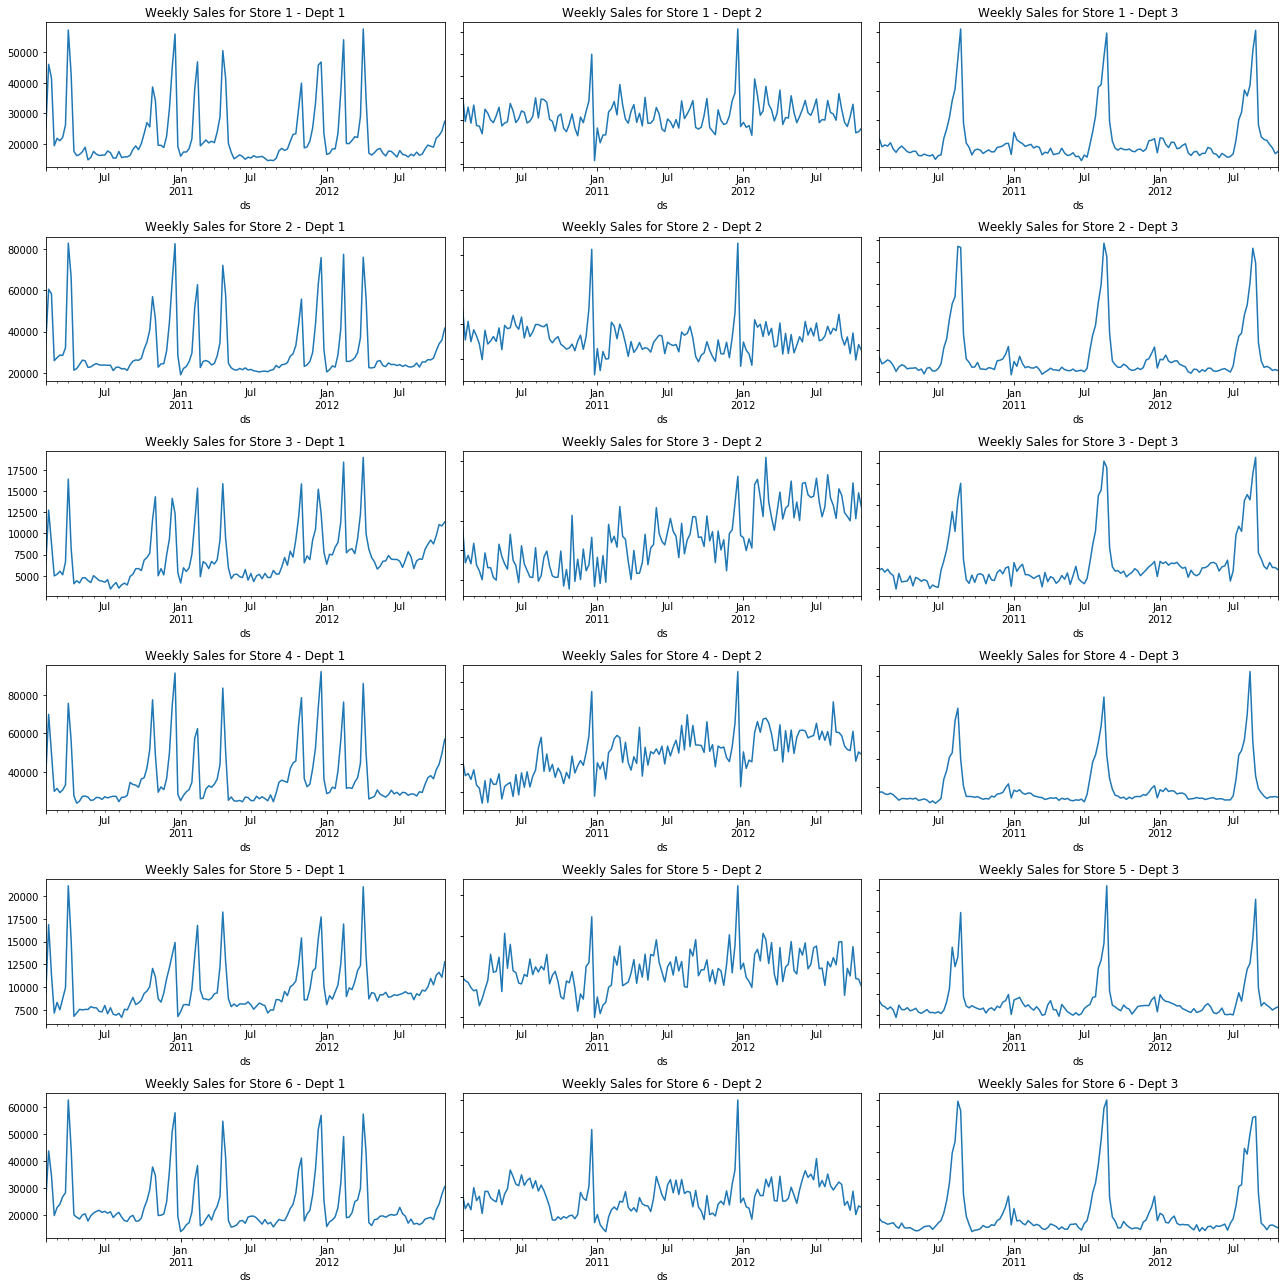

In [6]:
eda_sales(weekly_sales_df,store_locations=[1,2,3,4,5,6],departments=[1,2,3])
#eda_sales(weekly_sales_df,store_locations=stores,departments=depts)

In [7]:
## Get the holiday dates (from all stores/depts) 
events = weekly_sales_df[(weekly_sales_df['IsHoliday']==True)][['Date']]     

In [8]:
events['Date'].unique()

array(['2010-02-12T00:00:00.000000000', '2010-09-10T00:00:00.000000000',
       '2010-11-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000',
       '2011-02-11T00:00:00.000000000', '2011-09-09T00:00:00.000000000',
       '2011-11-25T00:00:00.000000000', '2011-12-30T00:00:00.000000000',
       '2012-02-10T00:00:00.000000000', '2012-09-07T00:00:00.000000000'], dtype='datetime64[ns]')

### fbProphet

In [9]:
## Create holiday df with lower and upper window = 0, as we do not want to extend the holiday out
# to days around the given date
def create_holidays_df():
    presidentsday_df = pd.DataFrame({
        'holiday': 'PresidentsDay',
        'ds': pd.to_datetime(['2/12/2010','2/11/2011','2/10/2012']),
        'lower_window': 0,
        'upper_window': 0
        })

    laborday_df = pd.DataFrame({
        'holiday': 'LaborDay',
        'ds': pd.to_datetime(['9/10/2010','9/9/2011','9/7/2012']),
        'lower_window': 0,
        'upper_window': 0
        })

    thanksgiving_df = pd.DataFrame({
        'holiday': 'LaborDay',
        'ds': pd.to_datetime(['11/26/2010','11/25/2011']),
        'lower_window': 0,
        'upper_window': 0
        })

    newyears_df = pd.DataFrame({
        'holiday': 'NewYearDay',
        'ds': pd.to_datetime(['12/31/2010','12/30/2011']),
        'lower_window': 0,
        'upper_window': 0
        })
    holidays_df = pd.concat((presidentsday_df, laborday_df, thanksgiving_df, newyears_df))
    return holidays_df

In [10]:
## Define a function to get individual store, dept sales and impute missing dates. Then call the func to perform model.
def forecast_sales(sales_df, stores, depts):    
    
    results_dict = collections.defaultdict(list) 
    
    # create holidays/promotions events df
    holidays_df = create_holidays_df()              
    
    for store in stores:
        for dept in depts:
            df_str_dept = sales_df[(sales_df['Store']==store) & (sales_df['Dept']==dept)][['Date', 'Weekly_Sales']]            
            df_str_dept = df_str_dept.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}) #rename the cols as needed by fbprophet            
            
            ## Find if there are missing dates in the df_str_dept df
               ## Get the date ranges in the df with all stores/depts
            daterange = pd.date_range(start=sales_df['Date'].min().date(),end=sales_df['Date'].max().date(), freq='W-FRI') 
            
               
            df_str_dept.set_index('ds',inplace=True)
            missing = sorted(set(daterange)  - set(df_str_dept.index))            
            
            if(len(missing) > 1):                
                df_str_dept = df_str_dept.reindex(daterange, fill_value=0) ## fill missing weekdays with 0
                df_str_dept = df_str_dept.rename_axis('ds').reset_index() ## change ds from index to col                
            else:
                df_str_dept = df_str_dept.rename_axis('ds').reset_index() ## change ds from index to col
             
            ##Split df into train and test data as 70/30 of df
            train_size = int(len(df_str_dept) * 0.70)
            train_df, test_df = df_str_dept[0:train_size], df_str_dept[train_size:len(df_str_dept)]  
            
            # Instantiate Prophet and include holiday effects & yearly_seasonality 
            # as our data follows yearly seasonal pattern
            model = Prophet(holidays=holidays_df, yearly_seasonality=True, 
                    weekly_seasonality=False, daily_seasonality=False) 
            model.add_seasonality(name='yearly', period='365.25', fourier_order=7)
            model.fit(train_df)
    
            # Define future timeframe, with len of test_df
            future = model.make_future_dataframe(periods=len(test_df), freq='W-FRI') 
    
            # Use predict method to forecast for the future timeframe
            forecast = model.predict(future)    

            #metrics - create df of predicted data and original data in test_df
            metrics_df = (forecast.set_index('ds')[['yhat']][test_df.index[0]:]).join(test_df.set_index('ds').y).reset_index()
            mse = mean_squared_error(metrics_df.y, metrics_df.yhat)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(metrics_df.y, metrics_df.yhat)
            
            results_dict[(store, dept)].append(rmse)
            results_dict[(store, dept)].append(mae)
    return results_dict

In [11]:
result = forecast_sales(weekly_sales_df, stores=[1,2,3,4,5], depts=[1,2,3,18])

In [12]:
result

defaultdict(list,
            {(1, 1): [6221.381253801942, 3781.8415660181904],
             (1, 2): [3029.4524901882382, 2575.5107106139944],
             (1, 3): [4048.0607888288696, 2313.6109292711362],
             (1, 18): [3439.0958079170882, 2279.935462692466],
             (2, 1): [9614.8593741367677, 6827.3795498958898],
             (2, 2): [4295.5112118694697, 3580.2968005438684],
             (2, 3): [4115.8691143535889, 2390.5822309838941],
             (2, 18): [4384.7643325195704, 2973.1360244244474],
             (3, 1): [2021.3375635531104, 1313.6357580424965],
             (3, 2): [1212.4551178541565, 958.48154542064105],
             (3, 3): [1409.8203672764439, 822.17331026407737],
             (3, 18): [1287.4542503740845, 993.45562820697842],
             (4, 1): [8885.9839378947127, 4814.9857133320802],
             (4, 2): [5136.0777534886229, 4101.8545037411168],
             (4, 3): [6205.4070273197949, 2989.2562302229071],
             (4, 18): [5474.63842823

In [14]:
    # Plot the forecst
    #model.plot(forecast, xlabel='Date', ylabel='Weekly Sales')
    #plt.title('Forecast graph for Store %d - Dept %d'%(store, dept),fontsize=18,color='blue')
    #model.plot_components(forecast);
    
    # Cross Validation
    #df_cv = cross_validation(model, horizon='120 days')
    #mse_cv = mean_squared_error(df_cv.y, df_cv.yhat)
    #rmse_cv = np.sqrt(mse_cv)
    #mae_cv = mean_absolute_error(df_cv.y, df_cv.yhat)